In [1]:
%pylab inline
import numpy as np
import timeit


import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
%load_ext Cython
import Cython.Compiler.Options as CO
CO.extra_compile_args = ['-O3']
CO.extra_link_args = ['-O3']

# Bilateral filter

Theory from [this paper](http://people.csail.mit.edu/sparis/publi/2009/fntcgv/Paris_09_Bilateral_filtering.pdf)

**Why not on GPU?**

This project seem to fit better GPU calculation. However, developping on CPU permits to use the memory hierarchy more than using GPU. Indeed the cache is bigger in the CPU which permits to get more context for a pixel in cache.  

As seen in this image from the class (credit Ray Thouis Jones): 

![credit Ray Thouis Jones](cacheCPUvsGPU.png)

Using the SIMD of AVX allows us to optimize performance on CPU calculation. However, this will be true only if the algorithm is **computation bound** and not **memory bound**. That is why we will pay special care to memory optimization in this project.


## input parameters

In [19]:
im_size = 64
sigma_r = 2.
sigma_s = 2.
truncate = 4.
lw = int(max(sigma_r, sigma_s)*truncate)

## generate image

<matplotlib.colorbar.Colorbar instance at 0x7efd848b41b8>

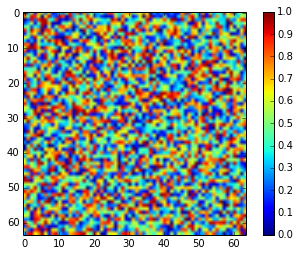

In [20]:
picture = np.random.random((im_size, im_size))
plt.imshow(picture);
plt.colorbar()

## helper function

In [21]:
def gaussian(x2, sigma):
    """get gaussian coefficient with x^2 as input"""
    return np.exp(-.5*x2/sigma**2)

The bilateral filter takes 2 inputs (and one optional):

 - sigma_r is the standard deviation of the bilateral filter
 - sigma_s is the standard deviation of the gaussian blur
 - truncate is the value at which we truncate. This is an optimization. We assume that the coefficient are negligeable at max(sigma)*truncate since the gaussian shape is exponentially decaying.

## preprocess

Here we pad around the input picture. This is necessary because we will take a window around the picture to compute its output value. In the current implementation we use the numpy.pad function and we use the 'reflect mode'.

We need to fit a multiple of 8 in the direction where we use AVX arrays. Here is a picture to better explain this idea.

![](input_preprocessing.PNG)

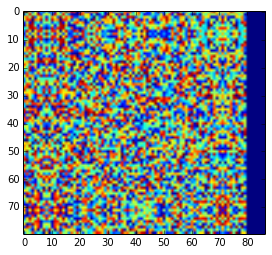

In [22]:
imsize = np.shape(picture)
input_im = np.zeros((lw + imsize[0] + lw, lw + imsize[1] + lw + 8 - (2 * lw + 1) % 8))
input_im[:(lw + imsize[0] + lw), :(lw + imsize[1] + lw)] = np.pad(picture, ((lw, lw), (lw, lw)), mode = 'reflect')
plt.imshow(input_im);

## filter algorithm

2 level of parallelism:

1. for each line in the window do a prange as showed in the picture

![](prange_in_window.PNG)


2. within the line use AVX

Nota Bene (illustrated in the figure below):

- [i,j] index in input_im
- [i-lw, j-lw]index in output

![ij](ij_loop.PNG)







# First approach (more flexible)

We load data by chunk of 8 (so that we can replace it with AVX array afterwards). See the design on the picture:
![](AVX_columnwise.PNG)



In [7]:
start = time.time()
output = picture * 0

# to implement with multi process
for i in range(lw, imsize[0] + lw):
    for j in range(lw, imsize[1] + lw):

        # window contining halo
        window = input_im[i - lw : i + lw + 1, j - lw : j + 1 + lw + 8 - (2 * lw + 1) % 8]
        assert np.shape(window) == (2 * lw +1, lw + 1 + lw + 8 - (2 * lw + 1) % 8)
        windowsize = np.shape(window)
        
        # initialize normalization term and output term
        sumg = 0
        local_output = 0
        I_pixel = window[lw, lw]
        
        for k in range(windowsize[0]):
            for l in range(0, windowsize[1], 8):
                # take local_input which will become an AVX 8-array
                local_input = window[k,l:l+8]
                assert np.size(local_input) == 8
                
                for cur in range(8):
                    # don't consider the pixel if it is outside the window
                    if l + cur < 2 * lw + 1:
                        coef = gaussian((k - lw)**2+(l + cur - lw)**2, sigma_s)
#                         coef *= gaussian((local_input[cur] - I_pixel)**2, sigma_r)
                        local_output += coef * local_input[cur]
                        sumg += coef
        
        output[i-lw, j-lw] = local_output / sumg

print "python ", time.time() - start

python  12.3086719513


scipy 0.0196659564972


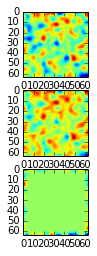

In [8]:
plt.subplot(311)
# our algorithm for gaussian filter
plt.imshow(output);
# plt.colorbar()

plt.subplot(312)
# scipy
from scipy.ndimage.filters import gaussian_filter1d, gaussian_filter
start = time.time()
blur = gaussian_filter(picture, 2)
plt.imshow(blur);
# plt.colorbar()
print "scipy", time.time() - start

plt.subplot(313)
# the difference
plt.imshow(blur-output)
# plt.colorbar()

### Cython

In [9]:
%%cython
import numpy as np
cimport numpy as np
cimport cython
from libc.math cimport exp
# cimport AVX
from cython.parallel import prange

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.initializedcheck(False)

cdef float gaussian(float x2,
                float sigma) nogil:
    """get gaussian coefficient with x^2 as input"""
    return exp(-.5*x2/sigma**2)

           
cpdef bilateral_filter_nopr(float sigma_s,
                        float sigma_r,
                        np.float32_t [:, :] input_im,
                        int imsize0,
                        int imsize1,
                        np.float32_t [:, :] output,
                        int lw):

    cdef:
        int i,j,k,l,cur
        np.float32_t [:, :] window
        np.float32_t [:] local_input
        int windowsize0, windowsize1
        float sumg, local_output, I_pixel, coef

    # to implement with multi process
    for i in range(lw, imsize0 + lw):
        for j in range(lw, imsize1 + lw):

            # window contining halo
            window = input_im[i - lw : i + lw + 1, j - lw : j + 1 + lw + 8 - (2 * lw + 1) % 8]
            if np.shape(window) != (2 * lw +1, lw + 1 + lw + 8 - (2 * lw + 1) % 8):
                print np.shape(window) , (2 * lw +1, lw + 1 + lw + 8 - (2 * lw + 1) % 8)
            assert np.shape(window) == (2 * lw +1, lw + 1 + lw + 8 - (2 * lw + 1) % 8)
            windowsize0, windowsize1 = np.shape(window)

            # initialize normalization term and output term
            sumg = 0
            local_output = 0
            I_pixel = window[lw, lw]

            for k in range(windowsize0):
                for l in range(0, windowsize1, 8):
                    # take local_input which will become an AVX 8-array
                    local_input = window[k,l:l+8]
                    assert np.size(local_input) == 8

                    for cur in range(8):
                        # don't consider the pixel if it is outside the window
                        if l + cur < 2 * lw + 1:
                            coef = gaussian((k - lw)**2+(l + cur - lw)**2, sigma_s)
                            coef *= gaussian((<float> local_input[cur] - I_pixel)**2, sigma_r)
                            local_output += coef * <float> local_input[cur]
                            sumg += coef

            output[i-lw, j-lw] = local_output / sumg


### prange

From [documentation](http://docs.cython.org/src/userguide/parallelism.html)

*cython.parallel.prange([start,] stop[, step][, nogil=False][, schedule=None[, chunksize=None]][, num_threads=None])*
This function can be used for parallel loops. OpenMP automatically starts a thread pool and distributes the work according to the schedule used. step must not be 0. This function can only be used with the GIL released. If nogil is true, the loop will be wrapped in a nogil section.

**Thread-locality and reductions are automatically inferred for variables.**

If you assign to a variable in a prange block, it becomes lastprivate, meaning that the variable will contain the value from the last iteration. If you use an inplace operator on a variable, it becomes a reduction, meaning that the values from the thread-local copies of the variable will be reduced with the operator and assigned to the original variable after the loop. The index variable is always lastprivate. Variables assigned to in a parallel with block will be private and unusable after the block, as there is no concept of a sequentially last value.

**The schedule is passed to OpenMP and can be one of the following:**

- static:
If a chunksize is provided, iterations are distributed to all threads ahead of time in blocks of the given chunksize. If no chunksize is given, the iteration space is divided into chunks that are approximately equal in size, and at most one chunk is assigned to each thread in advance.

This is most appropriate when the scheduling overhead matters and the problem can be cut down into equally sized chunks that are known to have approximately the same runtime.

- dynamic:
The iterations are distributed to threads as they request them, with a default chunk size of 1.

This is suitable when the runtime of each chunk differs and is not known in advance and therefore a larger number of smaller chunks is used in order to keep all threads busy.

- guided:
As with dynamic scheduling, the iterations are distributed to threads as they request them, but with decreasing chunk size. The size of each chunk is proportional to the number of unassigned iterations divided by the number of participating threads, decreasing to 1 (or the chunksize if provided).

This has an advantage over pure dynamic scheduling when it turns out that the last chunks take more time than expected or are otherwise being badly scheduled, so that most threads start running idle while the last chunks are being worked on by only a smaller number of threads.

- runtime:
The schedule and chunk size are taken from the runtime scheduling variable, which can be set through the openmp.omp_set_schedule() function call, or the OMP_SCHEDULE environment variable. Note that this essentially disables any static compile time optimisations of the scheduling code itself and may therefore show a slightly worse performance than when the same scheduling policy is statically configured at compile time.


**Barrier**

At the end of every  prange(),
there is an implicit barrier. All threads must reach the barrier before
computation continues.

In [10]:
%%cython
import numpy as np
cimport numpy as np
cimport cython
from libc.math cimport exp
# cimport AVX
from cython.parallel import prange

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.initializedcheck(False)

cdef float gaussian(float x2,
                float sigma) nogil:
    """get gaussian coefficient with x^2 as input"""
    return exp(-.5*x2/sigma**2)


cpdef bilateral_filter_pr(float sigma_s,
                        float sigma_r,
                        np.float32_t [:, :] input_im,
                        int imsize0,
                        int imsize1,
                        np.float32_t [:, :] output,
                        int lw,
                        int num_thread):

    cdef:
        int i,j,k,l,cur, ii
        np.float32_t [:, :] window
        np.float32_t [:] local_input
        int windowsize0, windowsize1
        float sumg, local_output, I_pixel, coef

    local_input = np.zeros(8, np.float32)


    # to implement with multi process
    for i in range(lw, imsize0 + lw):
        for j in range(lw, imsize1 + lw):

            # window contining halo
            window = input_im[i - lw : i + lw + 1, j - lw : j + 1 + lw + 8 - (2 * lw + 1) % 8]
            assert np.shape(window) == (2 * lw +1, lw + 1 + lw + 8 - (2 * lw + 1) % 8)
            windowsize0, windowsize1 = np.shape(window)

            # initialize normalization term and output term
            sumg = 0
            local_output = 0
            I_pixel = window[lw, lw]

            for k in prange(windowsize0, nogil = True, num_threads=num_thread):
                for l in range(0, windowsize1, 8):
                    # take local_input which will become an AVX 8-array
                    for ii in range(8):
                        local_input[ii] = window[k,l+ii]
#                     assert np.size(local_input) == 8

                    for cur in range(8):
                        # don't consider the pixel if it is outside the window
                        if l + cur < 2 * lw + 1:
                            coef = gaussian((k - lw)**2+(l + cur - lw)**2, sigma_s)
                            coef *= gaussian((<float> local_input[cur] - I_pixel)**2, sigma_r)
                            local_output += coef * <float> local_input[cur]
                            sumg += coef

            output[i-lw, j-lw] = local_output / sumg


### prange for j

In [56]:
%%cython
import numpy as np
cimport numpy as np
cimport cython
from libc.math cimport exp
# cimport AVX
from cython.parallel import prange

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.initializedcheck(False)

cdef float gaussian(float x2,
                float sigma) nogil:
    """get gaussian coefficient with x^2 as input"""
    return exp(-.5*x2/sigma**2)


cpdef bilateral_filter_pr_j(float sigma_s,
                        float sigma_r,
                        np.float32_t [:, :] input_im,
                        int imsize0,
                        int imsize1,
                        np.float32_t [:, :] output,
                        int lw):

    cdef:
        int i,j,k,l,cur, ii,ixx, xx, iyy, yy,_
        np.float32_t [:, :] window
        np.float32_t [:] local_input
        int windowsize0, windowsize1
        float sumg, local_output, I_pixel, coef
        np.float32_t [:] partial_output, partial_sumg

    local_input = np.zeros(8, np.float32)
    window = np.zeros((2 * lw +1, lw + 1 + lw + 8 - (2 * lw + 1) % 8), np.float32)
    windowsize0, windowsize1 = np.shape(window)


    # to implement with multi process
    for i in range(lw, imsize0 + lw):
        #initalize parameters
        partial_output = np.zeros(imsize1, np.float32)
        partial_sumg = np.zeros(imsize1, np.float32)

        for j in prange(lw, imsize1 + lw, nogil = True):

            # window contining halo
            for iyy, yy in enumerate(range(j - lw, j + 1 + lw + 8 - (2 * lw + 1) % 8)):
                for ixx, xx in enumerate(range(i - lw, i + lw + 1)):
                    window[ixx, iyy] = input_im[xx, yy]
#             window = input_im[i - lw : i + lw + 1, j - lw : j + 1 + lw + 8 - (2 * lw + 1) % 8]
#             assert np.shape(window) == (2 * lw +1, lw + 1 + lw + 8 - (2 * lw + 1) % 8)


            # initialize normalization term and output term
            I_pixel = window[lw, lw]

            for k in range(windowsize0):
                for l in range(0, windowsize1, 8):
                    # take local_input which will become an AVX 8-array
                    for ii in range(8):
                        local_input[ii] = window[k,l+ii]
#                     assert np.size(local_input) == 8

                    for cur in range(8):
                        # don't consider the pixel if it is outside the window
                        if l + cur < 2 * lw + 1:
                            coef = gaussian((k - lw)**2+(l + cur - lw)**2, sigma_s)
                            coef *= gaussian((<float> local_input[cur] - I_pixel)**2, sigma_r)
                            partial_output[j-lw] += coef * <float> local_input[cur]
                            partial_sumg[j-lw] += coef

        for _ in range(imsize1):
            output[i-lw, _] = partial_output[_] / partial_sumg[_]

### Optimization of memory

In [ ]:
%%cython
import numpy as np
cimport numpy as np
cimport cython
from libc.math cimport exp
# cimport AVX
from cython.parallel import prange

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.initializedcheck(False)

cdef float gaussian(float x2,
                float sigma) nogil:
    """get gaussian coefficient with x^2 as input"""
    return exp(-.5*x2/sigma**2)


cpdef bilateral_filter_pr_j(float sigma_s,
                        float sigma_r,
                        np.float32_t [:, :] input_im,
                        int imsize0,
                        int imsize1,
                        np.float32_t [:, :] output,
                        int lw):

    cdef:
        int i,j,k,l,cur, ii,ixx, xx, iyy, yy,_
        np.float32_t [:, :] window
        np.float32_t [:] local_input
        int windowsize0, windowsize1
        float sumg, local_output, I_pixel, coef
        np.float32_t [:] partial_output, partial_sumg

    local_input = np.zeros(8, np.float32)
    window = np.zeros((2 * lw +1, lw + 1 + lw + 8 - (2 * lw + 1) % 8), np.float32)
    windowsize0, windowsize1 = np.shape(window)


    # to implement with multi process
    for i in range(lw, imsize0 + lw):
        #initalize parameters
        partial_output = np.zeros(imsize1, np.float32)
        partial_sumg = np.zeros(imsize1, np.float32)

        for j in prange(lw, imsize1 + lw, nogil = True):

            # window contining halo
            for iyy, yy in enumerate(range(j - lw, j + 1 + lw + 8 - (2 * lw + 1) % 8)):
                for ixx, xx in enumerate(range(i - lw, i + lw + 1)):
                    window[ixx, iyy] = input_im[xx, yy]
#             window = input_im[i - lw : i + lw + 1, j - lw : j + 1 + lw + 8 - (2 * lw + 1) % 8]
#             assert np.shape(window) == (2 * lw +1, lw + 1 + lw + 8 - (2 * lw + 1) % 8)


            # initialize normalization term and output term
            I_pixel = window[lw, lw]

            for k in range(windowsize0):
                for l in range(0, windowsize1, 8):
                    # take local_input which will become an AVX 8-array
                    for ii in range(8):
                        local_input[ii] = window[k,l+ii]
#                     assert np.size(local_input) == 8

                    for cur in range(8):
                        # don't consider the pixel if it is outside the window
                        if l + cur < 2 * lw + 1:
                            coef = gaussian((k - lw)**2+(l + cur - lw)**2, sigma_s)
                            coef *= gaussian((<float> local_input[cur] - I_pixel)**2, sigma_r)
                            partial_output[j-lw] += coef * <float> local_input[cur]
                            partial_sumg[j-lw] += coef

        for _ in range(imsize1):
            output[i-lw, _] = partial_output[_] / partial_sumg[_]

### performance

#### accuracy

bilateral without range 0.665405988693
bilateral with prange 2th 0.325698137283
bilateral with prange j 0.340475082397


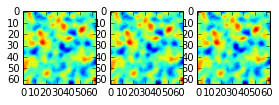

In [55]:
#run filter
num_thread =2
imsize0 = imsize[0]
imsize1 = imsize[1]
output = picture*0.
output5 =  np.array(output, np.float32)
input_im5 = np.array(input_im, np.float32)
start = time.time()
bilateral_filter_nopr(sigma_s,
                        sigma_r,
                        input_im5,
                        imsize0,
                        imsize1,
                        output5, 
                        lw)
print "bilateral without range", time.time() - start
plt.subplot(141)
plt.imshow(output5)

output = picture*0.
output5 =  np.array(output, np.float32)
input_im5 = np.array(input_im, np.float32)
start = time.time()
bilateral_filter_pr(sigma_s,
                        sigma_r,
                        input_im5,
                        imsize0,
                        imsize1,
                        output5, 
                        lw,
                   num_thread)
print "bilateral with prange 2th", time.time() - start
plt.subplot(142)
plt.imshow(output5)

output = picture*0.
output5 =  np.array(output, np.float32)
input_im5 = np.array(input_im, np.float32)
start = time.time()
bilateral_filter_pr_j(sigma_s,
                        sigma_r,
                        input_im5,
                        imsize0,
                        imsize1,
                        output5, 
                        lw)
print "bilateral with prange j", time.time() - start
plt.subplot(143)
plt.imshow(output5)

#### time

In [70]:
def time_update(function, truncate, imsize, picture, input_im, lw, num_thread=None):
    
    #cython parameters
    imsize0 = imsize[0]
    imsize1 = imsize[1]
    output = picture*0.
    output5 =  np.array(output, np.float32)
    input_im5 = np.array(input_im, np.float32)
    
    if num_thread is None:
        times = timeit.repeat(lambda: function(sigma_s,
                                                        sigma_r,
                                                        input_im5,
                                                        imsize0,
                                                        imsize1,
                                                        output5, 
                                                        lw), 
                            number=3, repeat=5)
    else:
        times = timeit.repeat(lambda: function(sigma_s,
                                                    sigma_r,
                                                    input_im5,
                                                    imsize0,
                                                    imsize1,
                                                    output5, 
                                                    lw,
                                                    num_thread), 
                            number=3, repeat=5)
    print("{} = {}: {}".format(str(function),truncate , min(times)))

    return min(times)

In [80]:
#time without prange
iters = 10
functions = [bilateral_filter_nopr,bilateral_filter_pr,bilateral_filter_pr_j]
th = [None, 1, None]
truncates = [k for k in range(iters)] 


times = [[0 for truncate in truncates] for fn in functions]


for k, fn in enumerate(functions):
    print str(fn)
    for truncate in truncates:
        lw = (max(sigma_r, sigma_s)*truncate)

        #preprocess
        imsize = np.shape(picture)
        input_im = np.zeros((lw + imsize[0] + lw, lw + imsize[1] + lw + 8 - (2 * lw + 1) % 8))
        input_im[:(lw + imsize[0] + lw), :(lw + imsize[1] + lw)] = np.pad(picture, ((lw, lw), (lw, lw)), mode = 'reflect')

        #time
        times[k][truncate] = time_update(fn, truncate, imsize, picture, input_im, lw, th[k])

<built-in function bilateral_filter_nopr>
<built-in function bilateral_filter_nopr> = 0: 0.101011991501
<built-in function bilateral_filter_nopr> = 1: 0.254093885422
<built-in function bilateral_filter_nopr> = 2: 0.679157972336
<built-in function bilateral_filter_nopr> = 3: 1.10809016228
<built-in function bilateral_filter_nopr> = 4: 1.96096992493
<built-in function bilateral_filter_nopr> = 5: 2.65593099594
<built-in function bilateral_filter_nopr> = 6: 3.93239212036
<built-in function bilateral_filter_nopr> = 7: 4.90622282028
<built-in function bilateral_filter_nopr> = 8: 6.60687112808
<built-in function bilateral_filter_nopr> = 9: 7.8379740715
<built-in function bilateral_filter_pr>
<built-in function bilateral_filter_pr> = 0: 0.0645999908447
<built-in function bilateral_filter_pr> = 1: 0.139708995819
<built-in function bilateral_filter_pr> = 2: 0.314797878265
<built-in function bilateral_filter_pr> = 3: 0.577579975128
<built-in function bilateral_filter_pr> = 4: 0.961967945099
<buil

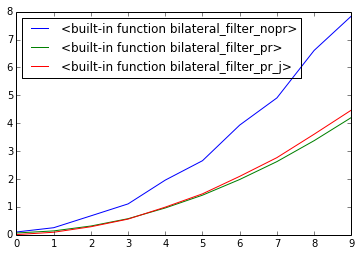

In [86]:
plt.plot(times[:][0], label = "{}".format(str(functions[0])))
plt.plot(times[:][1], label = "{}".format(str(functions[1])))
plt.plot(times[:][2], label = "{}".format(str(functions[2])))
plt.legend(loc="best")


#### Discussion

As expected we can see that the algorithm with prange is faster than the algorithm without prange. It is about twice faster.

The red curve corresponds to timing of the prange for j. And the green line corresponds to prange for k.
We see that the prange for j is performing slightly better than k in the beginning but after a truncation number of 4 prange for k performs better.

This must be due to the memory. prange for j is **memory bound**. The bigger the window is and the worse the effect on this prange will be because each thread needs to get the data for the window.

A potential optimization would be to load a larger window in the direction of j and to do the calculation more times with the data for the window **already in the cache and serialized**. Then we should tend towards a **compute bound**. Ideally we would like to see the effect of the cache size as the window size get bigger (which non linear and not exponential, as we did in class we should clearly see the difference between L1 and L2).


---

### With AVX

Advanced Vector Extensions (AVX) are extensions to the x86 instruction set architecture for microprocessors from Intel and AMD (from [Wikipedia](https://en.wikipedia.org/wiki/Advanced_Vector_Extensions)). My computer actually uses another extension which SS3 (because it was built before 2011).

**More's law**

As seen in class, the number of transistors per chip has increased following More's exponential law. Though the clock time has not (transistors get smaller but heat cannot be sucked out of the chips fast enough for a given area, thus the temperature increases and the chip melts). AVX uses the paradigm of **[SIMD](https://en.wikipedia.org/wiki/SIMD)**: "Single Instruction Multiple Data". The same instruction is done  8-way-parallel on multiple data **without concurrency.**

From this graph (studied in class) we see that today, a substantial increase in performance is dur to SIMD.

![performance plot](whyAVX.png)

AVX enables a performance increase only if the algorithm is **computationally intensive/ [CPU bound](http://stackoverflow.com/questions/868568/what-do-the-terms-cpu-bound-and-i-o-bound-mean)** (a typical example is mandelbrot which was extensively studied in class. However it should not speed things up much if the algorithm is **[I/O bound](http://stackoverflow.com/questions/868568/what-do-the-terms-cpu-bound-and-i-o-bound-mean) (+ [Serialization](https://msdn.microsoft.com/en-us/library/ms233843.aspx))**! We will be able to check this in our optimization study of the I/O. We will try our best to use the memory effectively so that there is a real gain in using AVX.

**NB:** I could not find a hack to compile AVX program within iPython so I compiled it on my computer and just plot the code without running it.

In [ ]:
# %%cython
import numpy as np
cimport numpy as np
cimport cython
from libc.math cimport exp
cimport AVX
from cython.parallel import prange

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.initializedcheck(False)

cdef float gaussian(float x2,
                float sigma) nogil:
    """get gaussian coefficient with x^2 as input"""
    return exp(-.5*x2/sigma**2)


cpdef bilateral_filter_AVX(float sigma_s,
                        float sigma_r,
                        np.float32_t [:, :] input_im,
                        int imsize0,
                        int imsize1,
                        np.float32_t [:, :] output,
                        int lw):

    cdef:
        int i,j,k,l,_
        np.float32_t [:, :] window
        np.float32_t [:] local_input
        int windowsize0, windowsize1
        np.float32_t [:] output_array, coef_array
        float sumg, local_output, I_pixel, coef
        AVX.float8 AVX_local_input, AVX_x, AVX_y, AVX_gauss_coef, AVX_bil_coef, AVX_coef1, AVX_coef2, AVX_coef, AVX_ouput, AVX_I, AVX_MAXx, mask

    # local_input = np.zeros(8, np.float32)
    AVX_gauss_coef = AVX.float_to_float8(-.5/sigma_s) #coef gaussian
    AVX_bil_coef = AVX.float_to_float8(-.5/sigma_r) #coef bilateral
    AVX_MAXx = AVX.float_to_float8(<float> 2 * lw + 1)

    # to implement with multi process
    for i in range(lw, imsize0 + lw):
        for j in range(lw, imsize1 + lw):

            # window contining halo
            window = input_im[i - lw : i + lw + 1, j - lw : j + 1 + lw + 8 - (2 * lw + 1) % 8]
            assert np.shape(window) == (2 * lw +1, lw + 1 + lw + 8 - (2 * lw + 1) % 8)
            windowsize0, windowsize1 = np.shape(window)

            # initialize normalization term and output term
            sumg = 0
            local_output = 0
            output_array = np.zeros(8, dtype= np.float32)
            coef_array = np.zeros(8, dtype= np.float32)
            I_pixel = window[lw, lw]
            AVX_I =  AVX.float_to_float8(<float> I_pixel)

            for k in prange(windowsize0, nogil = True):

                AVX_y =  AVX.float_to_float8(<float> (k-lw))

                for l in range(0, windowsize1, 8):
                    # take local_input which will become an AVX 8-array, with a rollover (using mod)
                    AVX_local_input = AVX.make_float8(window[k,(l)%(2 * lw + 1)], window[k,(l+1)%(2 * lw + 1)], window[k,(l+2)%(2 * lw + 1)], window[k,(l+3)%(2 * lw + 1)],
                    window[k,(l+4)%(2 * lw + 1)], window[k,(l+5)%(2 * lw + 1)],window[k,(l+6)%(2 * lw + 1)], window[k,(l+7)%(2 * lw + 1)])
                    AVX_x = AVX.make_float8(<float> l, <float> l+1, <float> l+2, <float> l+3, <float> l+4, <float> l+5, <float> l+6, <float> l+7)

                    #create mask
                    mask = AVX.less_than(AVX_x, AVX_MAXx)

                    # compute coefficient
                    #contribution from bilateral
                    AVX_coef1 = AVX.sub(AVX_local_input, AVX_I)
                    AVX_coef1 = AVX.mul(AVX_coef1, AVX_coef1)
                    AVX_coef1 = AVX.mul(AVX_coef1, AVX_gauss_coef)
                    #contribution from gaussian filter
                    AVX_coef2 = AVX.sub(AVX_x, AVX.float_to_float8(<float> lw))
                    AVX_coef2 = AVX.mul(AVX_coef2, AVX_coef2)
                    AVX_coef2 = AVX.fmadd(AVX_y, AVX_y, AVX_coef2)
                    AVX_coef2 = AVX.mul(AVX_coef2, AVX_bil_coef)
                    #final coef
                    AVX_coef = AVX.add(AVX_coef1, AVX_coef2)
                    # AVX_coef = AVX.exp(AVX_coef)

                    # output
                    AVX_ouput = AVX.mul(AVX_local_input, AVX.bitwise_and(mask, AVX_coef))

                    for _ in range(8):
                        output_array[_] = <np.float32_t> (<np.float32_t *> &AVX_ouput)[_]
                        local_output += output_array[_]
                        coef_array[_] = <np.float32_t> (<np.float32_t *> &AVX_coef)[_]
                        sumg += coef_array[_]

            output[i-lw, j-lw] = local_output / sumg


#### **About Serialization and I/O bound**

[Forum post](http://stackoverflow.com/questions/1685330/why-we-should-perfer-to-store-the-serialized-data-not-the-raw-code-to-db) and [discussion](https://mail.python.org/pipermail/cython-devel/2012-September/003159.html) about serialization. As seen in class, a serialization can be dealt with when using Python multiprocessing by sending slices(and not Cython openMP) which is a (efficent way to side-step)[https://docs.python.org/2/library/multiprocessing.html] the **[GIL](https://docs.python.org/2/glossary.html#term-global-interpreter-lock)**: "Global Interpreter Lock". We recall that the GIL prevents true multi-threading as seen in [article 1](http://www.jeffknupp.com/blog/2012/03/31/pythons-hardest-problem/) and [article 2](https://www.jeffknupp.com/blog/2013/06/30/pythons-hardest-problem-revisited/) by Jeff Knupp studied in class.

The trade-off is the following:

- Python multiprocess — high level, useful for I/Obound tasks but the double for loop we are doing for each pixel will might take too long if it is done in pure python.
- OpenMP Threading — low level, more efficient, fewer structures but can have a problem with I/O bound task

2 ways forwards:

- optimize I/O using Cython prange (openMP) by doing some memory optimization
- try to run Python multiprocessing sharing slices 
- Use multithreading if we are really I/O bound. We can call a cython function that drops the GIL see [this piazza comment on HW2 P4](https://piazza.com/class/icqfmi2aryn6yv?cid=385) "The "with nogil:" section in median_3x3 drops the GIL, but continues to compute. This allows another Python thread to run (and enter that region, as well)."

#### About cache

[This link](http://www.extremetech.com/extreme/188776-how-l1-and-l2-cpu-caches-work-and-why-theyre-an-essential-part-of-modern-chips)

+ lecture 09-23

[on memoryview](http://docs.cython.org/src/userguide/memoryviews.html)

[arrays in python](http://docs.cython.org/src/tutorial/array.html)